# Text Analysis - State of the Union Speeches
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) </b>

Corinne Knoepfel    (11-613-676)

Sebastian Rieger    (17-621-152)

Simon Sommer        (13-604-913)

29.05.2018

--------------------------------------------------------------------------------------------
In this assignment we conduct text analysis on the US' State of the Union speeches. The analysis spans each step from data acquisition and storage, over preprocessing and vectorisation, up to feature extraction and visualisation.

As a first step, after preparing the data, we produce a Wordcloud as a form of explorative plot. This graph gives a visual indication of which words feature most prominently in State of the Union speeches.

The second part of our analysis focusses on finding the most common topics, that State of the Union speeches deal with. To find these topics we apply the Latent Dirichlet Allocation (LDA), which produces the five most important words, defining each of the most common topics. In interpreting these word groups, we define the suggested common topics. We continue to analyse, in what time frames and with what prominency  the topics show up in State of the Union speeches.

Thirdly we explore the differences in State of the Union Speeches of Democrats and Republicans. This we do on the basis of the 'Term frequency - Inverse Document Frequency'(Tf-Idf). While the Tf-Idf for single words shows little distinction between the two parties' speeches, there are stark differences in relation to the political agenda, when comparing the Tf-Idf of bigrams. In a second step we analyse, how the parties' speeches differ in relation to the topics most common topics, which yields results that are in line with our inuition on the parties' political agenda.

In a final step, just for fun, we trained a neural network text generator on the State of the Union Speeches and generated our very own speech. In case one of us ever ends up in the oval office, we are ready!

----------------------------------------------------------------------------------------------
Each step is described in more detail in the introductory mark-up before each part of the exercise. The output is freuqently also commented in a mark-up, adding additional intuition to the graphs.

In various parts of this exercise we draw on codes for plots or single functions, that we obtained from other sources. Whereever this is the case, we clearly made a reference in the code.

-----------------------------------------------------------------------------------------------
Contents:
<ol>
    <p> Data acquisition, data storage and defining preprocessing functions </p>
<p> Wordcloud </p>
<p> Topic Modelling with Latent Dirichlet Allocation </p>
<p> Differences between Speeches of Democrats and Republicans </p>
<p> Text Generating </p>
</ol>


In [6]:
#import modules
from bs4 import BeautifulSoup
import requests
import errno

%matplotlib inline

import os
import re
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\corin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data acquisition, data storage and defining preprocessing functions

### Download State of the Union Speeches
The State of the Union speeches are scraped from the website: http://stateoftheunion.onetwothree.net/texts/index.html

In [7]:
def get_all_speeches():
    #main function to download all speeches and put them in the directory "all_speeches"
    make_directory()
    all_links = get_all_links("http://stateoftheunion.onetwothree.net/texts/index.html")
    text_files_of_speeches(all_links)

    
def get_all_links(index_link):
    #goes onto the main page and saves each link to the page with the specific speech
    page = requests.get(index_link)
    soup = BeautifulSoup(page.content, "html.parser")
    body = soup.find_all("ul")
    all_links_unformatted = [tag['href'] for tag in body[1].select('a[href]')]
    all_links = []
    for unformatted_link in all_links_unformatted:
        link = "http://stateoftheunion.onetwothree.net/texts/" + unformatted_link
        all_links.append(link)
        
    return all_links


def text_files_of_speeches(all_links):
    #goes to page with speech, saves the date and name of president, gets the text of the speech and saves
    #all in a txt in the directory "all_speeches"
    for link in all_links:
        page = requests.get(link)
        soup = BeautifulSoup(page.content, "html.parser")
        body = soup.find_all("div", id="text")
        president = body[0].find("h2").text
        date = body[0].find("h3").text
        speech = ""
        paragraphs = body[0].find_all("p")
        for paragraph in paragraphs:
            get_text = paragraph.text
            speech = speech + get_text
            
        f = open("all_speeches/" + president + date + ".txt" ,"w+")
        f.write(speech)
        f.close()
        
def make_directory():
    #makes the directory "all_speeches" if it didn't exist already
    try:
        os.makedirs("all_speeches")
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [8]:
#get_all_speeches()
#takes a few minutes - only run if you don't already have the files


### Loading speeches into pandas dataframe
Putting the speeches together with info on the president and the year into one dataframe

In [9]:
path = "all_speeches/"

df = pd.DataFrame()                 #create a dataframe with text & information on president and year
for file in os.listdir(path):
    with open(os.path.join(path,file),"r", encoding="utf-8") as infile:
        txt = infile.read()
    metainfo = file.split(",")   #take president and year information from file name
    president, year = metainfo[0], metainfo[1]
    year = year.split(".")[0].strip()
    for ch in president:
        if ch.isupper():
            letter = ch
    index = president.rfind(letter)
    president = president.strip()[0:index].strip() 
    df = df.append([[txt, president, year]], ignore_index=True)

df.columns = ["text", "president", "year"]

#arrange data so speeches are ordered by year
df = df.sort_values("year")
df.reset_index(drop=True, inplace=True)

### Preprocessing - Cleaning up the text data
For various analyses we use different preprocessed text data to fit our needs. Check the beginning of each chapter to see, which preprosseing we use.

In [10]:
def preprocessor(text):
    '''removing all punctuation, non-letter characters and white spaces'''
    text.strip()
    text = (re.sub('[\W]+', ' ', text.lower()))      #remove non-word characters and make text lowercase
    text = (re.sub('[\d]+', '', text)) #to remove numbers [0-9]
    text = (re.sub('\n', ' ', text))
    return text.strip()

def tokenizer(text):
    '''split text into single words and return a list of these words'''
    return text.split()

def remove_stopwords(text):
    stop = stopwords.words('english')
    words = [word for word in text.split()]
    stopremoved = [w for w in words if w not in stop]
    return ' '.join(stopremoved)

def tokenizer_porter(text):
    '''Porter stemmer - split text and convert all words back to 
    their stem, e.g. running -> run, return a list of the stemmed words'''
    
    stop = stopwords.words('english')
    porter = PorterStemmer()
    
    stem = [porter.stem(word) for word in text.split()]
    stopremoved = [w for w in stem if w not in stop] #removing common stop words as downloaded from nltk package
    return " ".join(stopremoved)

# Wordcloud
For a first impression of the data we are dealing with we produce a wordcloud, which visualises the frequency of words used. The module for producing wordclouds is taken from a repository written by Andreas Mueller.
- [Source](https://github.com/amueller/word_cloud)
- [Website](http://amueller.github.io/word_cloud/)

As is to be expected from State of the Union speeches we find "government", "united state", "american" to be commonly used words. There are also some words such as "may" or "upon" that are not excluded by the stopwords-list and add little insight into the content of the speeches.

In [11]:
#apply preprocessor for Wordcloud and merge all preprocessed speeches to one text
wordcloud_df = df['text'].apply(preprocessor)
wordcloud_df = wordcloud_df.apply(remove_stopwords)

full_text = ''
for text in wordcloud_df:
    full_text += text

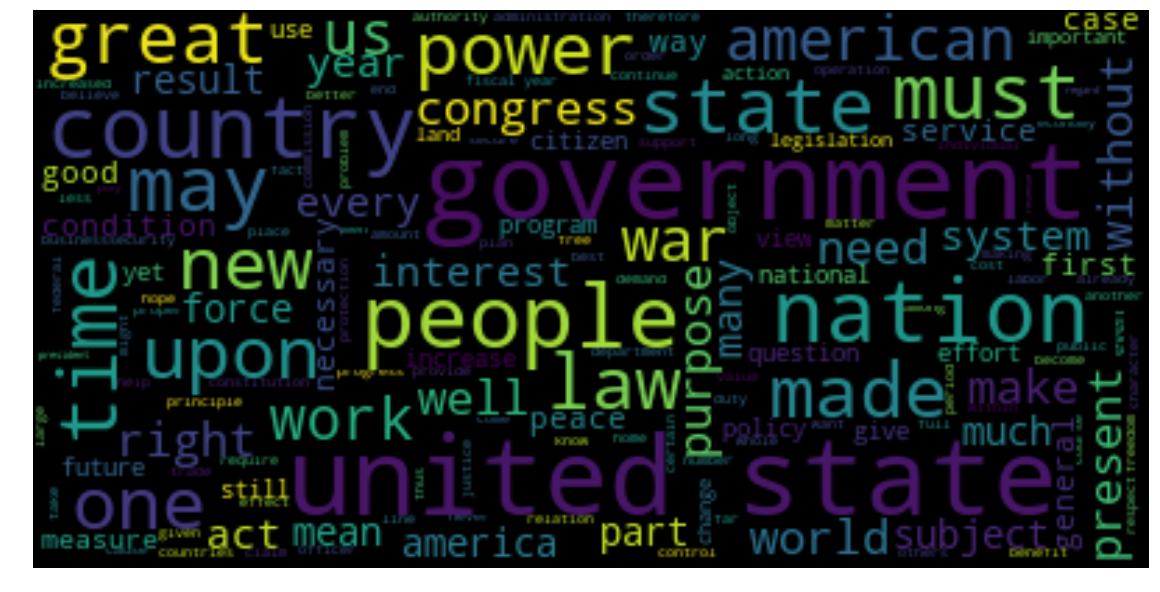

In [12]:
from wordcloud import WordCloud

# generate word cloud 
wordcloud = WordCloud(max_font_size=40).generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Topic Modelling with Latent Dirichlet Allocation
In this chapter we apply the Latent Dirichlet Allocation (LDA) to the data, in order to find the 5 most common topics in the State of the Union speeches. In our specification the LDA produces the five most important words, defining each of the most common topics, as seen in the output below. We interpret these word groups and come up with the topics:
<ol>
    <p> 1. freedom and terrorism</p>
<p> 2. international politics</p>
<p> 3. the administration</p>
<p> 4. economy</p>
<p> 5. politics and matters of state</p>
</ol>

In a second step we look at, which presidents' speeches had the overall highest correlation with these topics, i.e. to whom were these common topics most important. The first topic, for example, yields the following plausible results:

Presidents, whose speeches had the highest correlation with the topic "freedom and terrorism":
<ol>
<p> 1. Ronald Reagan</p>
<p> 2. George W. Bush</p>
<p> 3. George H.W. Bush</p>
</ol>

We then continue to plot, how much weight in the presidents' speeches is given to each of the five topics, which shows in what time frame specific topics became relevant. In a second figure, we overlay these correlations and show how each presidents' speeches were divided into these 5 topics.

We feel that the classification into just 5 topics may be a bit too crude to pick up the variety of topics that were commonly adressed in the State of the Union speeches. Therefore we repeat this exercise with 10 topics.

Overall we find, that the grouping into common topics works decently well. The resulting topics seem overall plausible and the correlations with presidents matches historical intuition. There does seem to be a distinct trade-off, when choosing the number of topics, by which to classify the speeches. When taking just 5 topics we loose out on picking up on  some of the relevant topics in American politics. When taking 10 topics, however, some of the suggested classifications become difficult to interpret, such as "Money Politics" reoccuring as popular topic in seemingly random episodes.

----------------------------------------------------
Chapter 8 'Applying Machine Learning to Sentiment Analysis' in 'Python Machine Learning' by Sebastian Raschka has been used as inspiration. Some code snippets - e.g. for the text preprocessing and for the implementation of the LDA - have been used as sample code.

### Finding 5 most common topics in SOTU speeches

In [13]:
#apply preprocessor for LDA

#apply preprocessor to speeches in data frame
df['text'] = df['text'].apply(preprocessor)

#Processing documents into tokens (incl. stemming and removing stopwords)
df['text'] = df['text'].apply(tokenizer_porter)

In [14]:
#Transformation Into Feature Vectors that count how often words appear in different speeches
count = CountVectorizer(stop_words="english", max_df=.9, max_features=10000)
X = count.fit_transform(df['text'].values)  #sparse matrix
    
#fit LDA 
lda = LatentDirichletAllocation(n_topics=5, random_state=123, learning_method='batch')
X_topics = lda.fit_transform(X)

lda.components_.shape
#print 5 most important words of every topic
print("The five most important words of the five topics are:")
print()
n_top_words = 5
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))

C:\Users\corin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


The five most important words of the five topics are:

Topic 1:
challeng free america terror iraqi
Topic 2:
world america program help need
Topic 3:
dure offic depart report recommend
Topic 4:
need men industri busi legisl
Topic 5:
duti constitut subject treati shall


We see can interpret the topics as follows:

<ol>
    <p> 1. freedom and terrorism</p>
<p> 2. international politics</p>
<p> 3. the administration</p>
<p> 4. economy</p>
<p> 5. politics and matters of state</p>
</ol>

### Which presidents talked most about the 5 topics?

In [29]:
#for topic 1 to 5
print('Presidents in order of gving most weight to the specific topics')

titles = ['#1: Terrorism', '#2: International Politics', '#3: Administration', 
          '#4: Economy', '#5: Matters of State']
for no in range(5):
    topic = X_topics[:, no].argsort()[::-1]  #sort in descending order and return index 
    print()
    print("Topic", titles[no])
    print('-'*40)
    presi = []
    for speech in topic:
        presi.append(df['president'][speech])
        if len(set(presi)) == 3: #make sure we only pick the 3 top presidents who belong in topic the most
            break 
            
    #Keep order in list but remove duplicates
    output = []
    seen = set()
    for p in presi:
        # If value has not been encountered yet, add it to both list and set.
        if p not in seen:
            output.append(p)
            seen.add(p)

    for p in output:
        print(p)

Presidents in order of gving most weight to the specific topics

Topic #1: Terrorism
----------------------------------------
Zachary Taylor
Millard Fillmore
Grover Cleveland

Topic #2: International Politics
----------------------------------------
Franklin Pierce
Herbert Hoover
Franklin D. Roosevelt

Topic #3: Administration
----------------------------------------
Andrew Jackson
George Washington
John Quincy Adams

Topic #4: Economy
----------------------------------------
Lyndon B. Johnson
Dwight D. Eisenhower
John F. Kennedy

Topic #5: Matters of State
----------------------------------------
Thomas Jefferson
James Madison
James Monroe


### When were the common topics most relevant?
Let's see how the different topics developed over the years and presidents. We take an average over all speeches for every president.

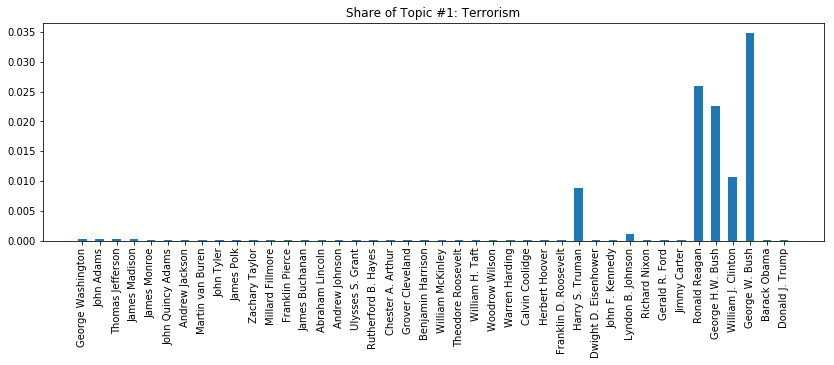

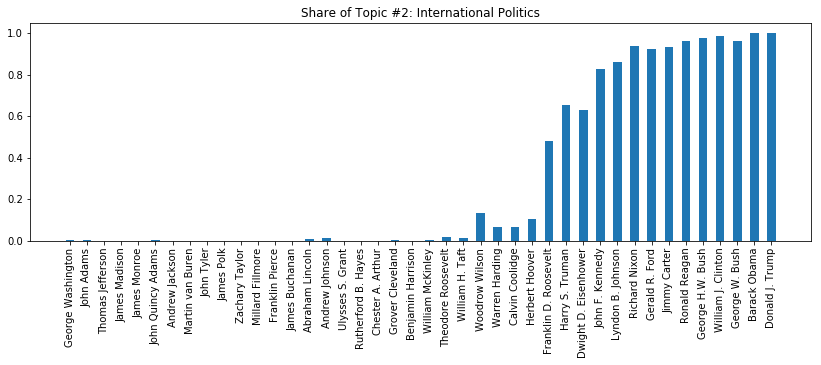

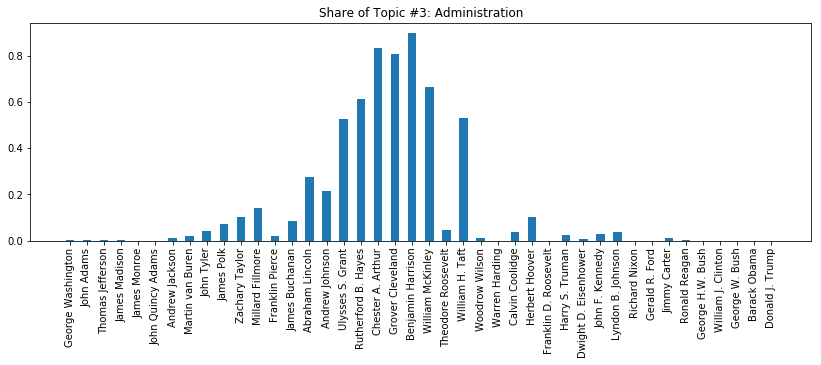

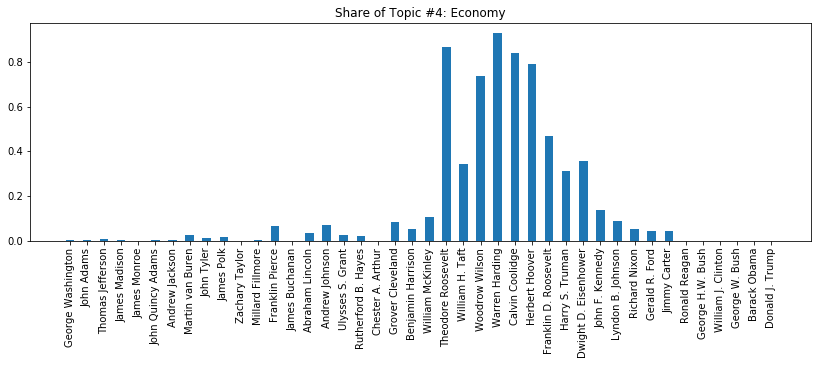

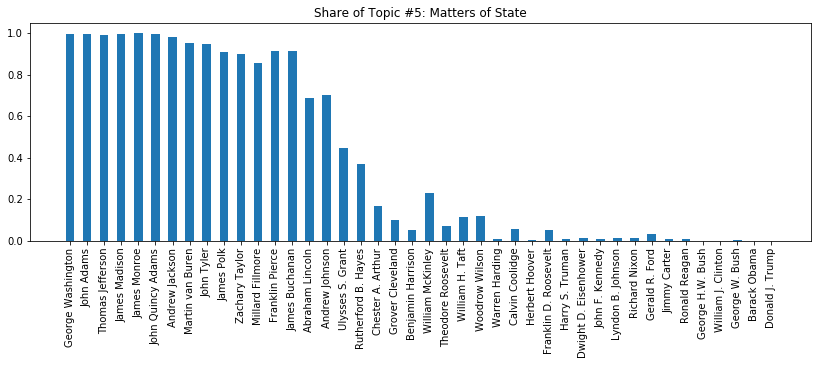

In [16]:
pset = set()  #set of all presidents
plist = []
for p in df['president']:
    if p not in pset:
        plist.append(p)
        pset.add(p)

weights=[]  #take the average over all speeches per president
for p in plist:
    line=[]
    indices = df.index[df['president'] == p]
    for i in indices:
        line.append(list(X_topics[i]))
    weights.append(list(np.mean(line, axis=0)))

#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 

#Plot for every single topic
titles = ['Share of Topic #1: Terrorism', 'Share of Topic #2: International Politics', 'Share of Topic #3: Administration', 
          'Share of Topic #4: Economy', 'Share of Topic #5: Matters of State']

for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    fig = plt.figure(figsize=(14,4))
    plt.bar(ind, t, width=width)
    plt.xticks(rotation=90)
    plt.xticks(ind , plist)
    plt.title(titles[x])

It's easy to see that the topics changed over the years quite drastically. While earlier presidents mostly addressed matters of state, that is the State of the Union (go figure!), the weight has shifted towards international policitcs. It's interesting to see that terrorism never dominated the speech but entered the address quite apruptly in the second half of the 19th century and was only a point in the Reagon, Clinton, and Bush Administration.

### How much did each president talk about each topic - in relative terms?
Now, let's have a look at how the speeches of the different presidents were split amongst the topics.This gives us a better idea as to the weights the different topics had at the time and also as to the presidents' agendas.

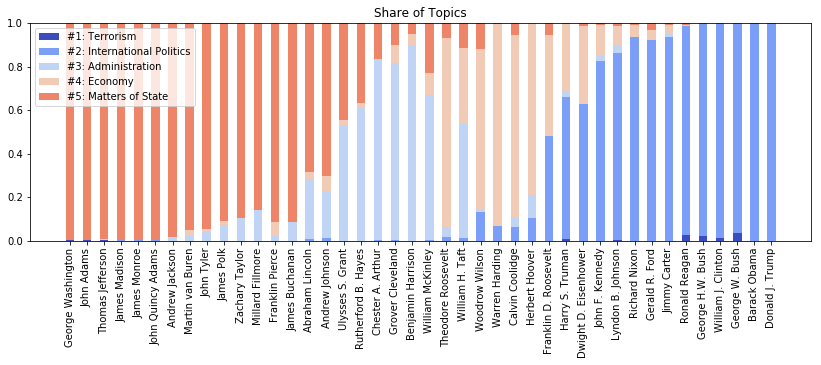

In [17]:
# #Stacked Bar plot
#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 
plots = []
height_cumulative = np.zeros(N)

s = []
for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    s.append(t)  #a list with 5 list, each with the weights on the respective topic per president
    
fig = plt.figure(figsize=(14,4))
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, s[k], width, color=color)
    else:
        p = plt.bar(ind, s[k], width, bottom=height_cumulative, color=color)
    height_cumulative += s[k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.title('Share of Topics')
plt.xticks(rotation=90)
plt.xticks(ind , plist)

titles = ['Share of Topic #1: Terrorism', 'Share of Topic #2: International Politics', 'Share of Topic #3: Administration', 
          'Share of Topic #4: Economy', 'Share of Topic #5: Matters of State']
for i in range(len(titles)):
    titles[i] = titles[i][15:]

plt.legend(titles ,loc=2)
print()

It's easy to see that a big switch happened between talking about matters of state (national politics) to talking about international politics. The transition phase seems to be dominated by concerns regarding the administration and the economy. Even though the Bush, Clinton, and Reagon administration talked about terrorism, the topic is almost negligible. 

### How do things change if we look for the 10 most common topics? 
### Finding 10 most common topics in SOTU speeches

The challenge of LDA modelling is, that it delivers as many topics as we ask for, consolidating or fusing topics as necessary to deliver the results we demand. Here is an example with 10 topics:

In [18]:
#fit LDA 
lda = LatentDirichletAllocation(n_topics=10, random_state=123, learning_method='batch')
X_topics = lda.fit_transform(X)

lda.components_.shape
#print 5 most important words of every topic
print("The five most important words of the ten topics are:")
print()
n_top_words = 5
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))

C:\Users\corin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


The five most important words of the ten topics are:

Topic 1:
challeng america famili futur dream
Topic 2:
america help world job tax
Topic 3:
gold note treasuri bond silver
Topic 4:
veri shall men thought task
Topic 5:
men need busi condit labor
Topic 6:
mexico texa mexican territori th
Topic 7:
dure offic depart report secretari
Topic 8:
world free program defens need
Topic 9:
subject duti constitut treati shall
Topic 10:
feder program econom recommend administr


These topics seem to make sense as well, they even revolve around the same themes: We see can interpret the topics as follows:
<ol> 
 <p> 1. family and future</p>
    <p> 2. international programs and support</p>
    <p> 3. money policies</p>
    <p> 4. World War speeches</p>
    <p> 5. economy and jobs</p>
    <p> 6. southern border</p>
    <p> 7. administration</p>
    <p> 8. freedom and defense</p>
    <p> 9. politics and matters od state</p>
    <p> 10. economic policies</p>
</ol>

### Which presidents talked most about the 10 topics?

In [19]:
#for topic 1 to 5
print('Presidents in order of highest correlation with topics')

titles = ['#1: Family and Future', '#2: International Politics', '#3: Money Politics', 
          '#4: World Wars', '#5: Economy and Jobs', '#6: Southern Border', 
          '#7: Administration', '#8: Freedom and Defense', '#9: Matters of State', 
          '#10: Economic Policies']   
for no in range(10):
    topic = X_topics[:, no].argsort()[::-1]  #sort in descending order and return index 
    print()
    print("Topic", titles[no])
    print('-'*40)
    presi = []
    for speech in topic:
        presi.append(df['president'][speech])
        if len(set(presi)) == 3: #make sure we only pick the 3 top presidents who belong in topic the most
            break 
            
    #Keep order in list but remove duplicates
    output = []
    seen = set()
    for p in presi:
        # If value has not been encountered yet,
        # ... add it to both list and set.
        if p not in seen:
            output.append(p)
            seen.add(p)

    for p in output:
        print(p)

Presidents in order of highest correlation with topics

Topic #1: Family and Future
----------------------------------------
Ronald Reagan
William J. Clinton
George H.W. Bush

Topic #2: International Politics
----------------------------------------
William J. Clinton
Barack Obama
George W. Bush

Topic #3: Money Politics
----------------------------------------
Grover Cleveland
James Madison
Donald J. Trump

Topic #4: World Wars
----------------------------------------
Woodrow Wilson
Franklin D. Roosevelt
Theodore Roosevelt

Topic #5: Economy and Jobs
----------------------------------------
Theodore Roosevelt
Woodrow Wilson
Warren Harding

Topic #6: Southern Border
----------------------------------------
James Polk
John Tyler
Millard Fillmore

Topic #7: Administration
----------------------------------------
Grover Cleveland
William McKinley
William H. Taft

Topic #8: Freedom and Defense
----------------------------------------
Dwight D. Eisenhower
Harry S. Truman
Franklin D. Rooseve

### When were the common topics most relevant?
Let's see how the different topics developed over the years and presidents. We take an average over all speeches for every president.

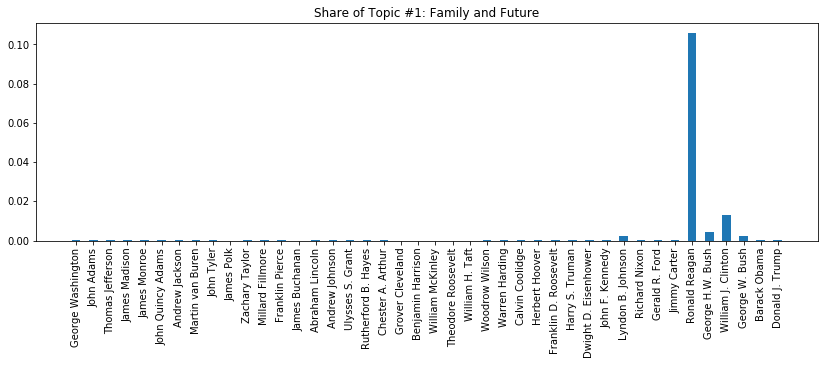

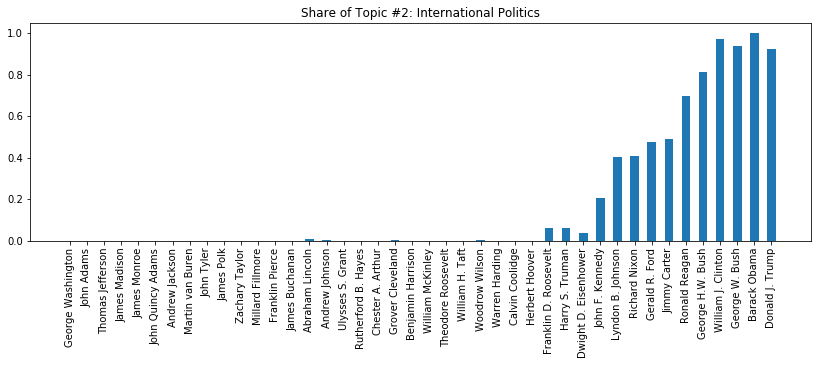

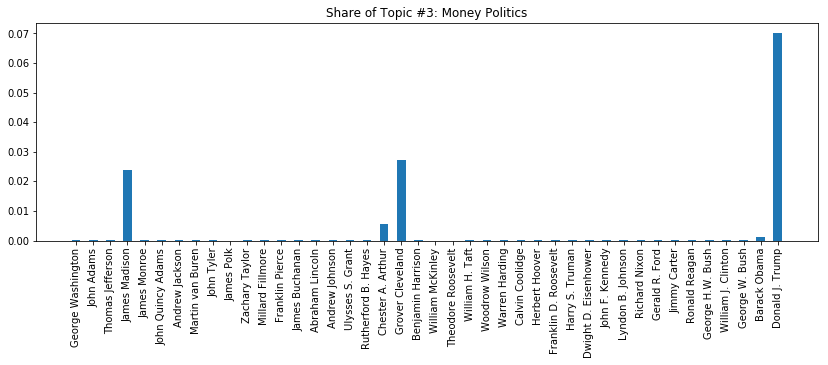

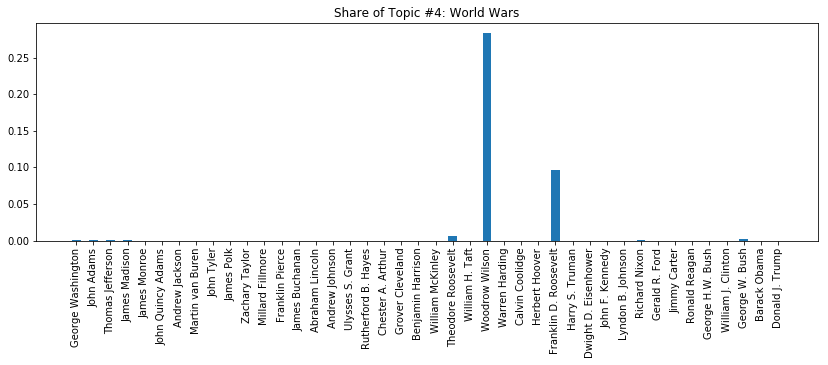

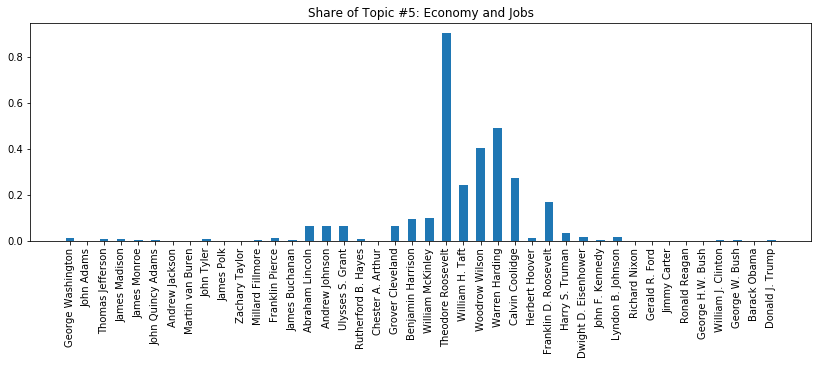

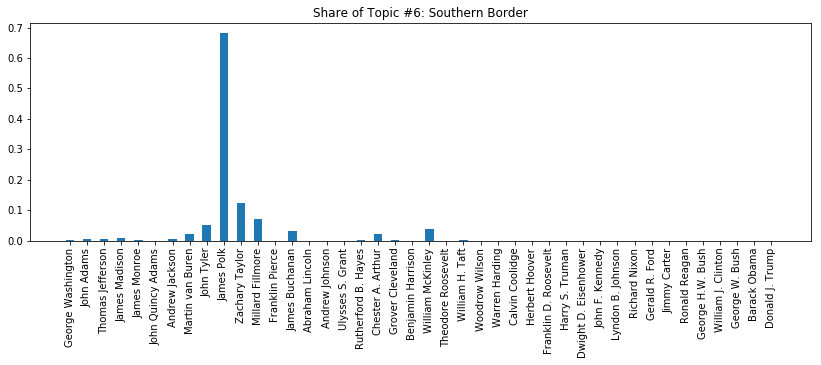

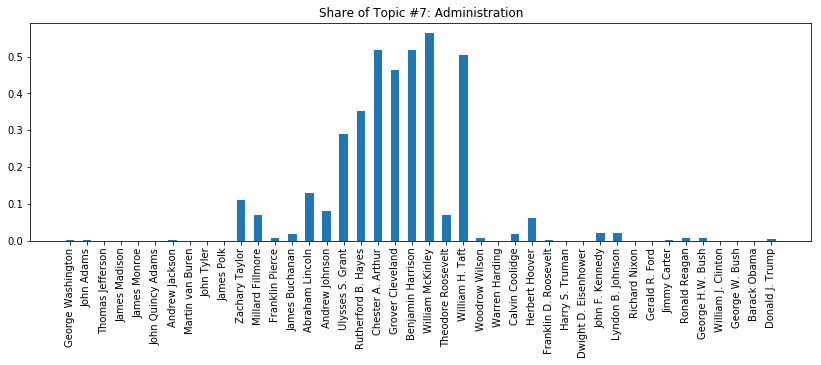

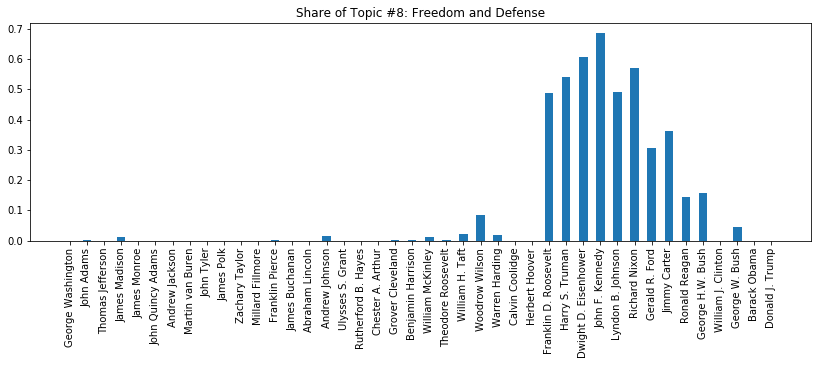

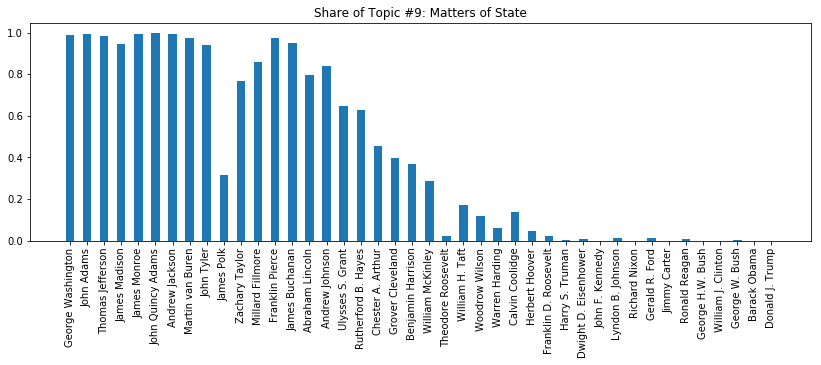

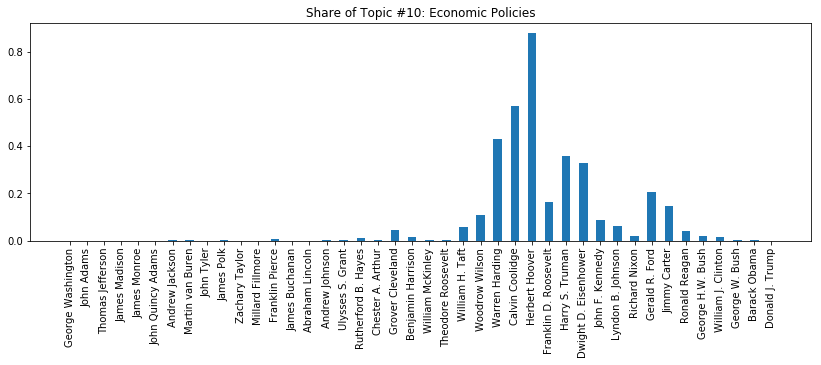

In [20]:
pset = set()  #set of all presidents
plist = []
for p in df['president']:
    if p not in pset:
        plist.append(p)
        pset.add(p)

weights=[]  #take the average over all speeches per president
for p in plist:
    line=[]
    indices = df.index[df['president'] == p]
    for i in indices:
        line.append(list(X_topics[i]))
    weights.append(list(np.mean(line, axis=0)))

#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 

#Plot for every single topic
titles = ['Share of Topic #1: Family and Future', 'Share of Topic #2: International Politics', 'Share of Topic #3: Money Politics', 
          'Share of Topic #4: World Wars', 'Share of Topic #5: Economy and Jobs', 'Share of Topic #6: Southern Border', 
          'Share of Topic #7: Administration', 'Share of Topic #8: Freedom and Defense', 'Share of Topic #9: Matters of State', 
          'Share of Topic #10: Economic Policies']    
    
for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    fig = plt.figure(figsize=(14,4))
    plt.bar(ind, t, width=width)
    plt.xticks(rotation=90)
    plt.xticks(ind , plist)
    plt.title(titles[x])

While the big drivers remained the same (compared to 5 topics), it's interesting to see how certain topics spring up: 
The southern border was a big topic in the wake of the texas revolution (war for independence from Mexico) when Texas was joining the USA, Freedom and Defense became a topic in the 20th century, just before WWII and in the period following the war. That makes a lot of sense. Other topics, however, are harder to justify, such as money policies that appears every now and then or future and family which was only a topic for Reagan. This could be a sign that we are forcing LDA into too many topics. 

(Note: Wilson was president before, during and after WWI. So, he probably had reason to model the SOTU speeches in his own way. A closer look at his speeches reveals that he talked a lot about tasks that needed to be done and the men whose duty it was to do them (both in industry and defense). Similarly, F.D. Roosevelt was president before and during WWII. Quite obviously, our LDA picked up on a "Speeches demanded by World Wars"-Topic. Ridicolously fascinating!). 

### How much did each president talk about each topic - in relative terms?
Now, let's have a look at how the speeches of the different presidents were split amongst the topics.This gives us a better idea as to the weights the different topics had at the time and also as to the presidents' agendas.

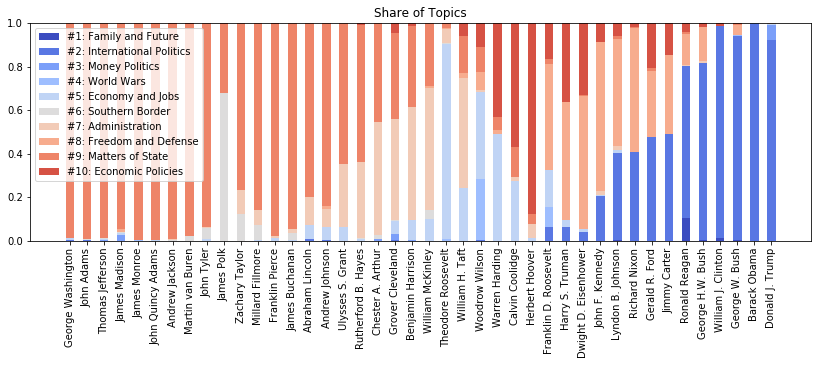

In [21]:
# #Stacked Bar plot
#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 
plots = []
height_cumulative = np.zeros(N)

s = []
for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    s.append(t)  #a list with 5 list, each with the weights on the respective topic per president
    
fig = plt.figure(figsize=(14,4))
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, s[k], width, color=color)
    else:
        p = plt.bar(ind, s[k], width, bottom=height_cumulative, color=color)
    height_cumulative += s[k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.title('Share of Topics')
plt.xticks(rotation=90)
plt.xticks(ind , plist)

titles = ['Share of Topic #1: Family and Future', 'Share of Topic #2: International Politics', 'Share of Topic #3: Money Politics', 
          'Share of Topic #4: World Wars', 'Share of Topic #5: Economy and Jobs', 'Share of Topic #6: Southern Border', 
          'Share of Topic #7: Administration', 'Share of Topic #8: Freedom and Defense', 'Share of Topic #9: Matters of State', 
          'Share of Topic #10: Economic Policies']   
for i in range(len(titles)):
    titles[i] = titles[i][15:]

plt.legend(titles,loc=2)
print()

Once again, we see the big shift from Matters of State to International Politics. However, now we have a finer grid and see other, smaller topics pop up and vanish again, presumably depending on the 'Zeitgeist' and the agenda of the respective president. 

Examples are: Freedom and Defense in the wake of WWII, concerns regarding the Administration and the Economy in the 19th century, and the concerns regarding the southern border when Texas was joining the USA. 

# Differences between Speeches of Democrats and Republicans
In this chapter we compare the speeches of Democrats and Republicans. In a first step we import match each president with his party membership. We drop the speeches of those presidents, who weren't members of a political party.

When then continue to compute the 'Term frequency - Inverse Document Frequency'. We analyse which words were most frequently used by both Party's State of the Union speeches. Unfortunately a large number of most frequent words does not convey a lot of information with regards to the political agenda - even after removing stop words.

We get a better insight into the political agenda when taking a look at the most frequnt bigrams. Speeches of Democratic presidents often touched on health care and a sense of liberal political ideology, with bigrams like "free nations" or "free world". Even when taking all Republican SOTU speeches ever delivered, we still see that the names "Saddam Hussein" and "al qaida" are among the most freuquently used bigrams. This indicates howmuch these bigrams must have dominated speeches of the last 20 years to make it to the top of the Tf-Idf list.

In a third step we revisit the topic modelling exercise and find the 5 most commonly used topics for the dataset, where speeches are limited presidents being party members. Here, we analyse, how important the topics are for Democratic and Republican speeches. We notice significant constrasts in the prominence of speeches. The overall topic, which we interpret as "Social Welfare", is more commonly referred to in Democratic speeches. The topic, which we interpret as "Future and Security" is correlated more strongly with Republican speeches. This is in line with our intuition, regarding the respective parties political agenda.

### Loading speeches into pandas dataframe
We need a different type of preprocessing than for the LDA. So we need to reload the data:

In [22]:
df = pd.DataFrame()                 #create a dataframe with text & information on president and year
for file in os.listdir(path):
    with open(os.path.join(path,file),"r", encoding="utf-8") as infile:
        txt = infile.read()
    metainfo = file.split(",")   #take president and year information from file name
    president, year = metainfo[0], metainfo[1]
    year = year.split(".")[0].strip()
    for ch in president:
        if ch.isupper():
            letter = ch
    index = president.rfind(letter)
    president = president.strip()[0:index].strip() 
    df = df.append([[txt, president, year]], ignore_index=True)

df.columns = ["text", "president", "year"]

#arrange data so speeches are ordered by year
df = df.sort_values("year")
df.reset_index(drop=True, inplace=True)

#apply preprocessor to speeches in data frame
df['text'] = df['text'].apply(preprocessor)
df['text'] = df['text'].apply(remove_stopwords)

### Augmenting our dataframe with party data 
Importing a csv-file that contains information on each president's party membership. We thereby can differentiate between speeches of Democrats and speechs of Republicans. We do lose a few speeches, where presidents were not members of a political party or, in isolated cases, the name president didn't match the name in the csv file.

In [23]:
#import csv
presidents_metadata = pd.read_csv("us_presidents.csv", date_parser=['start', 'end'])

# only keep name and party
presidents_metadata = presidents_metadata[['president', 'party']]



# match presidents and party (not easy because the names do not correspond)
parties = []

for text_name in df['president']:
    current_party = None
    for index, tup in presidents_metadata.iterrows():

        meta_name = tup[0]
        meta_party = tup[1]

        if text_name[-5:] == meta_name[-5:]:
            current_party = meta_party
            
    parties.append(current_party)

df['party'] = pd.Series(parties)

democrats = df[df['party'] == 'Democratic']
republicans = df[df['party'] == 'Republican']

print("Number of democrat speeches: ", len(democrats))
print("Number of republican speeches ", len(republicans))
#Number of democrat speeches:  101
#Number of republican speeches  79
# -> we lose a few speeches here, but not too many

both_parties = pd.concat((democrats, republicans)).reset_index(drop=True)

Number of democrat speeches:  101
Number of republican speeches  79


### Term-frequency - Inverse-document-frequency: Required functions
The following 5 functions for TF-IDF have been written by Thomas Buhrmann, to be found [here](https://buhrmann.github.io/tfidf-analysis.html).

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)


def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        if df.label == 'Democratic':
            ax.barh(x, df.tfidf, align='center', color='b')
        else:
            ax.barh(x, df.tfidf, align='center', color='r')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

### TF-IDF: Democrats vs. Republicans
Let's see which words were most commonly used in speeches of Democrats and Republicans (after removing stop-words)

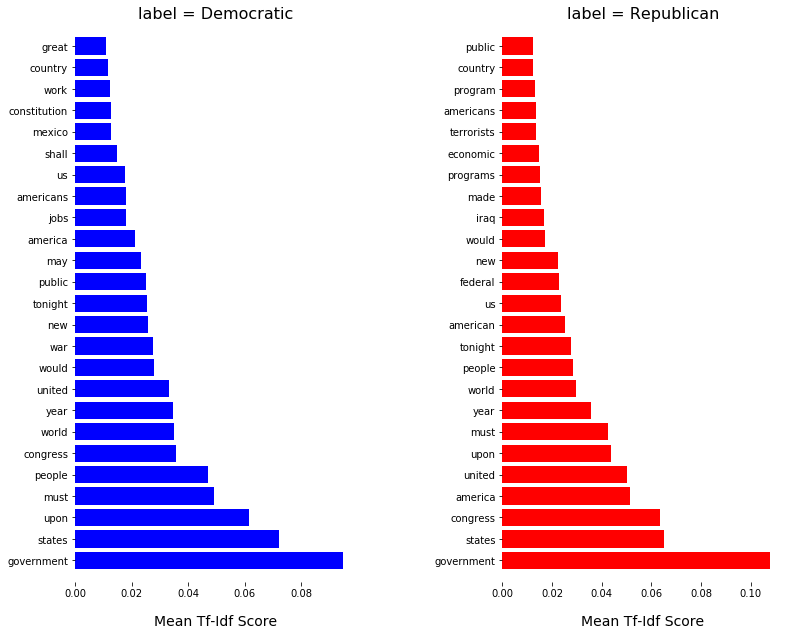

In [25]:
vectorizer = TfidfVectorizer()

Xtr = vectorizer.fit_transform(both_parties['text'])
features = vectorizer.get_feature_names()

dfs = top_feats_by_class(Xtr, both_parties['party'], features)

plot_tfidf_classfeats_h(dfs)

For both Democrats and Republicans the most common words provide little insight into the content of the speeches. Somewhat agaist political stereotypes the first word that might pertain to a political agenda, in the case of the Democrats, is the word "war", which is followed by "jobs". For the Rebublicans the most common words, conveying significant meaning, are the words "Iraq" and "Terrorists".

### TF-IDF for Bigramms: Democrats vs. Republicans
Let's see which bigramms were most commonly used in speeches of Democrats and Republicans (after removing stop-words)

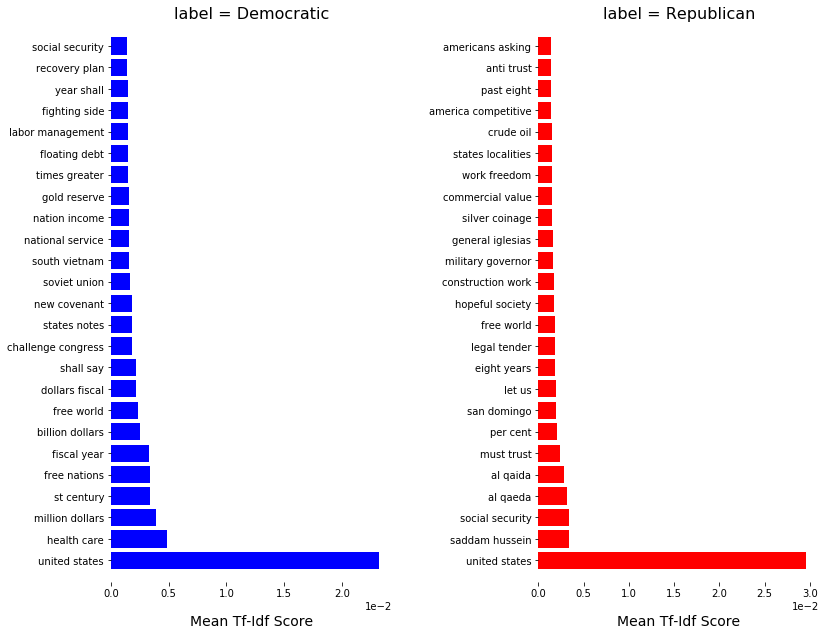

In [26]:
# using bigrams
vectorizer = TfidfVectorizer(ngram_range=(2,2))

Xtr = vectorizer.fit_transform(both_parties['text'])
features = vectorizer.get_feature_names()

dfs = top_feats_by_class(Xtr, both_parties['party'], features)

plot_tfidf_classfeats_h(dfs)

This chart seems to convey a lot more information pertaining to the agenda of the political parties. Speeches of Democratic presidents often touched on health care and a sense of liberal political ideology, with bigrams like "free nations" or "free world". Even when taking all Republican SOTU speeches ever delivered, we still see that the names "Saddam Hussein" and "al qaida" are among the most freuquently used bigrams. This indicates howmuch these bigrams must have dominated speeches of the last 20 years to make it to the top of the Tf-Idf list.

### Topic modelling to compare Democrats vs Republicans
Let's compare how important the five main topics are for the speeches of Democrats and Republicans.

In [36]:
#Transformation Into Feature Vectors that count how often words appear in different speeches
vectorizer = CountVectorizer(stop_words="english", max_df=.9, max_features=10000)
X = vectorizer.fit_transform(both_parties['text'].values)  #sparse matrix

#fit LDA 
lda = LatentDirichletAllocation(n_topics=5, random_state=123, learning_method='batch')
X_topics = lda.fit_transform(X)

parties = list(set(both_parties['party']))
topics = ['Social Welfare', 'Economic Policies', 'Economy and Employment', 
          'Future and Security', 'International Politics']
topic_scores = pd.DataFrame(X_topics, columns=topics)

#topic_scores.head()
#both_parties.head()

presidents_and_scores = pd.concat([both_parties,topic_scores], axis=1)

#print 5 most important words of every topic
print("The five most important words of the five topics are:")
print()
n_top_words = 8
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))

C:\Users\corin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


The five most important words of the five topics are:

Topic 1:
america need know americans let help jobs today
Topic 2:
federal economic program administration legislation shall security development
Topic 3:
present necessary business service general commerce conditions man
Topic 4:
america americans tonight help let children budget security
Topic 5:
general present service shall subject foreign treaty department


The topics are a bit difficult to interpret (we were only able to use part of the data set, due to the fact that not all presidents belonged to one or the other party, especially in the beginning of US history). That's not so surpising, after all the party line was not always very clear and even shifted over the decades and centuries. Here is an attempt:

<ol>
<p> 1. Internal problems and social welfare</p>
<p> 2. Economic policies</p>
<p> 3. Economy and Employmemt</p>
<p> 4. The Nation's Future and Security</p>
<p> 5. International Politics</p>
</ol>

Let's have a look at which presidents felt most at home in the different topics:

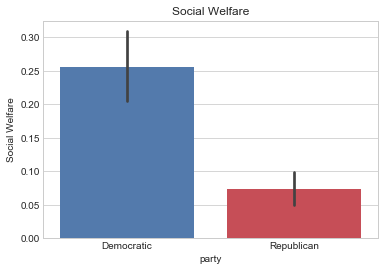

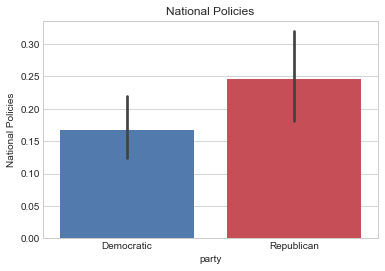

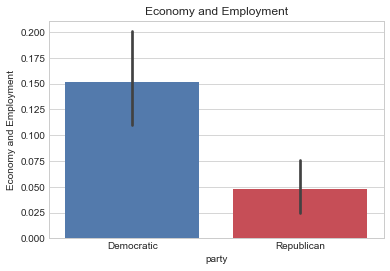

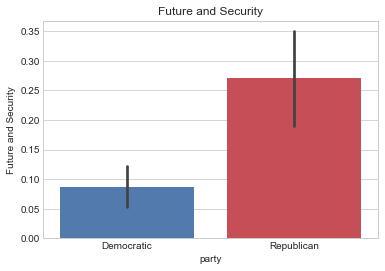

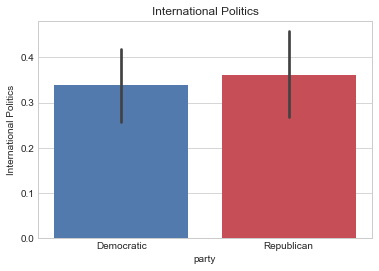

In [35]:
sns.set_style("whitegrid")

for topic in topics:
    plt.figure()
    plt.title(topic)
    with sns.color_palette(sns.diverging_palette(250, 10, n=2)):
        sns.barplot(x='party', y=topic, data=presidents_and_scores);
     

We notice significant constrasts in the prominence of topics. The first topic, which we interpret as "Social Welfare", was more commonly referred to in Democratic speeches. The topic, which we interpret as "Future and Security" is referred to more often in Republican speeches.

# Text Generation

Just for fun we trained a neural network text generator on the State of the Union Speeches (20th century only, to limit the amount of data). Be aware that the majority of the code for this was written for another project and only slightly adjusted to suit our data. We trained our model for 2hrs on a GPU (this could be prolongued infinitely to get better results, but wasn't done for cost reasons). To try it out yourself, download the trained model (whole folder) from our [google drive](https://drive.google.com/open?id=10DjUPdUXEaFDMG-yKmpmgAbmMlBOHu6H) and run the `text_generator.ipynb` notebook (requires tensorflow).

An example output generated by our model is given below:

    mr speaker, distinguished members of the senate bill and i
    recommend that he should authorize a communication with a completeness that not made this
    month, we have worked under the personal action of the national history of man on earth,
    afghanistan. mexico are beginning to come up to defense, particularly as they came to our
    national debate. we honor tonight. but we are moving no movement of free nations to our
    agriculture and leadership to find such a way toward national survival and from
    both parties. we constantly these principles, we have been moving towards making progress toward improvement
    that will develop new housing shifting the various policies and
    protect the rights of our people. to lose, sympathetic and dependable agreements in the spirit
    of international cooperation, which requires that it will be
    so because an american diplomacy is our policy through the continued cooperation of the united
    states vastly improved the relations we have completed half the foundation of
    a law which i recommended that action be given to the recently independent
    such seven classes, with a view to the due consideration of my recommendations:
    this congress has thus to do with a thorough reconsideration of
    federal support. this would emphasize both of these objectives if we create them,
    american agriculture more just as well. but new nations must be determined-- but a record high
    over how many years of communist aggression now. we have worked to improve their
    control and ways of making effective areas our balance of payments.
    this plan would encourage such authority to protect american commerce and to recommend to
    the railroads of the republics of nicaragua and the other departments. several of
    our economy is to formulate a provision of adequate personnel to greater
    development. the new legislation has led to decrees dissolving the exchange of
    american foreign trade in december, 1979, when the foreign representatives of
    this overwhelming government can have been arrested and the
    administration of consideration for these programs now are now being pressing with their
    organization and success of which i have left to have a place and senate to
    report

While this is far from perfect, it indicates the potential of such methods.